![header](https://i.ibb.co/kHXgpXS/Bitcoin-Banner-1900-x-500.jpg)

# Cryptocurrency Time Series
***
Authors: [TJ Bray](https://www.linkedin.com/in/thomas-tj-bray-24499354/), [Aalok Joshi](https://www.linkedin.com/in/aalokjoshi113/), [Paul Lindquist](https://www.linkedin.com/in/paul-lindquist/)

## Overview
***
TBD

## Business Objective
***
TBD

## Data
***
This project uses [datasets](https://www.kaggle.com/yamqwe/cryptocurrency-extra-data-bitcoin) from Kaggle user [Yam Peleg](https://www.kaggle.com/yamqwe) created for the ***[G-Research Crypto Forecasting](https://www.kaggle.com/c/g-research-crypto-forecasting)*** competition.

## Methodology
***
We employ time series analysis, modeling and forecasting.

## Library Imports
***

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import statsmodels.tsa.api as tsa
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import STL
from pandas.plotting import register_matplotlib_converters
from scipy.stats import boxcox
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
import statsmodels.api as sm

%matplotlib inline

## Data Imports and Concatenation
***

In [2]:
def get_data(coin = 'bitcoin', year = 2017):
    
    df = pd.read_csv(f'./data/{coin}_{year}.csv')
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit = 's')
    df.set_index('timestamp', inplace = True)
    df.sort_index(inplace = True)
    df = df[['Count','Open','High','Low','Close','Volume','VWAP','Target']]
    
    return df

In [3]:
btc2017 = get_data()
btc2018 = get_data('bitcoin', 2018)
btc2019 = get_data('bitcoin', 2019)
btc2020 = get_data('bitcoin', 2020)
btc2021 = get_data('bitcoin', 2021)

In [4]:
btc = pd.concat([btc2017, btc2018, btc2019, btc2020, btc2021], axis = 0)

## Data Cleaning and Exploratory Data Analysis
***

In [5]:
btc.tail()

,Count,Open,High,Low,Close,Volume,VWAP,Target
timestamp,,,,,,,,
2021-12-22 23:39:00,393.0,48685.09,48688.45,48657.61,48666.75,18.23746,113568.310000,-9.540979e-18
2021-12-22 23:40:00,296.0,48666.74,48667.14,48652.38,48660.47,5.68742,113539.676667,-6.613633e-18
2021-12-22 23:41:00,301.0,48660.47,48663.84,48658.13,48659.31,7.38479,113541.740000,-7.372575e-18
2021-12-22 23:42:00,582.0,48659.31,48659.31,48633.78,48633.80,14.44861,113504.356667,1.321371e-19
2021-12-22 23:43:00,978.0,48633.80,48635.15,48586.68,48594.20,25.04675,113419.896667,5.529431e-18


In [6]:
def resample(df, time_period = '1d'):
    df1 = df[['Open']].resample(time_period).first()
    df2 = df[['Close']].resample(time_period).last()
    df3 = df[['Volume']].resample(time_period).sum()
    df = pd.concat([df1,df2,df3], axis = 0).sort_index().groupby('timestamp').sum()
    return df

In [7]:
def add_cols(df):
    
    df['log_open'] = np.log(df['Open'])
    df['log_close'] = np.log(df['Close'])

    #let's make sure this is correct
    df['return'] = np.log(df['Close']/df['Close'].shift(1)).shift(1)
                          
    for i in range(7):
        days_ago = f'close_{i+1}_prior'
        df[days_ago] = df['log_close'].shift(i+1)
    
    df['sma_7'] = df['Close'].rolling(7).mean().shift(1)
    df['sma_30'] = df['Close'].rolling(30).mean().shift(1)
    df['sma_50'] = df['Close'].rolling(50).mean().shift(1)
    df['sma_200'] = df['Close'].rolling(200).mean().shift(1)

    df['dist_sma_7'] = (df['Close'] - df['sma_7']).shift(1)
    df['dist_sma_30'] = (df['Close'] - df['sma_30']).shift(1)
    df['dist_sma_50'] = (df['Close'] - df['sma_50']).shift(1)
    df['dist_sma_200'] = (df['Close'] - df['sma_200']).shift(1)
    
    df['momentum_7'] = df['return'].rolling(7).mean().shift(1)
    df['momentum_30'] = df['return'].rolling(30).mean().shift(1)
    df['momentum_50'] = df['return'].rolling(50).mean().shift(1)
    df['momentum_200'] = df['return'].rolling(200).mean().shift(1)
    
    df['volatility_7'] = df['return'].rolling(7).std().shift(1)
    df['volatility_30'] = df['return'].rolling(7).std().shift(1)
    df['volatility_50'] =  df['return'].rolling(50).std().shift(1)
    df['volatility_200'] = df['return'].rolling(200).std().shift(1)
    
    df['volume_7'] = df['Volume'].rolling(7).mean().shift(1)
    df['volume_14'] = df['Volume'].rolling(14).mean().shift(1)
    df['volume_30'] = df['Volume'].rolling(30).mean().shift(1)
    df['volume_50'] = df['Volume'].rolling(50).mean().shift(1)
    
    df.drop(['Volume'], axis = 1, inplace = True)
    df.dropna(inplace = True)
    
    return df

In [8]:
daily = add_cols(resample(btc))

In [9]:
daily

,Open,Close,log_open,log_close,return,close_1_prior,close_2_prior,close_3_prior,close_4_prior,close_5_prior,...,momentum_50,momentum_200,volatility_7,volatility_30,volatility_50,volatility_200,volume_7,volume_14,volume_30,volume_50
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-07-07,6602.941429,6752.501429,8.795270,8.817668,0.010569,8.794999,8.784430,8.792935,8.780534,8.797065,...,-0.004886,-0.005302,0.027785,0.027785,0.033861,0.053411,74896.827362,80062.843292,83779.893017,81538.060967
2018-07-08,6755.638333,6704.184286,8.818133,8.810487,0.022669,8.817668,8.794999,8.784430,8.792935,8.780534,...,-0.003996,-0.005248,0.020892,0.020892,0.033667,0.053421,70545.218843,79090.881971,83599.824901,81075.744116
2018-07-09,6706.365000,6661.478571,8.810812,8.804097,-0.007181,8.810487,8.817668,8.794999,8.784430,8.792935,...,-0.003979,-0.004703,0.019881,0.019881,0.033680,0.053145,70893.331436,73388.811688,83643.323221,81209.998621
2018-07-10,6662.305714,6302.410000,8.804221,8.748687,-0.006390,8.804097,8.810487,8.817668,8.794999,8.784430,...,-0.004111,-0.004500,0.020048,0.020048,0.033679,0.053057,67323.079659,71106.155748,84323.605457,81369.042204
2018-07-11,6303.092857,6379.651667,8.748796,8.760869,-0.055409,8.748687,8.804097,8.810487,8.817668,8.794999,...,-0.004927,-0.004220,0.014203,0.014203,0.033217,0.052898,70074.414081,73684.409544,81923.513076,82075.280369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-18,46133.830000,46834.480000,10.739302,10.754375,-0.032023,10.739245,10.771268,10.796816,10.786083,10.751558,...,-0.004081,0.001449,0.039128,0.039128,0.034263,0.037913,38916.595751,46384.088133,45794.324466,43946.663427
2021-12-19,46834.470000,46681.230000,10.754375,10.751097,0.015130,10.754375,10.739245,10.771268,10.796816,10.786083,...,-0.005448,0.001065,0.040971,0.040971,0.033980,0.037861,38363.861341,40013.850916,44556.759579,43567.586398
2021-12-20,46681.240000,46914.160000,10.751098,10.756075,-0.003278,10.751097,10.754375,10.739245,10.771268,10.796816,...,-0.005692,0.001221,0.036036,0.036036,0.033783,0.037855,38833.543119,38851.342811,43843.086892,43524.138018


In [10]:
daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1265 entries, 2018-07-07 to 2021-12-22
Data columns (total 32 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Open            1265 non-null   float64
 1   Close           1265 non-null   float64
 2   log_open        1265 non-null   float64
 3   log_close       1265 non-null   float64
 4   return          1265 non-null   float64
 5   close_1_prior   1265 non-null   float64
 6   close_2_prior   1265 non-null   float64
 7   close_3_prior   1265 non-null   float64
 8   close_4_prior   1265 non-null   float64
 9   close_5_prior   1265 non-null   float64
 10  close_6_prior   1265 non-null   float64
 11  close_7_prior   1265 non-null   float64
 12  sma_7           1265 non-null   float64
 13  sma_30          1265 non-null   float64
 14  sma_50          1265 non-null   float64
 15  sma_200         1265 non-null   float64
 16  dist_sma_7      1265 non-null   float64
 17  dist_sma_30    

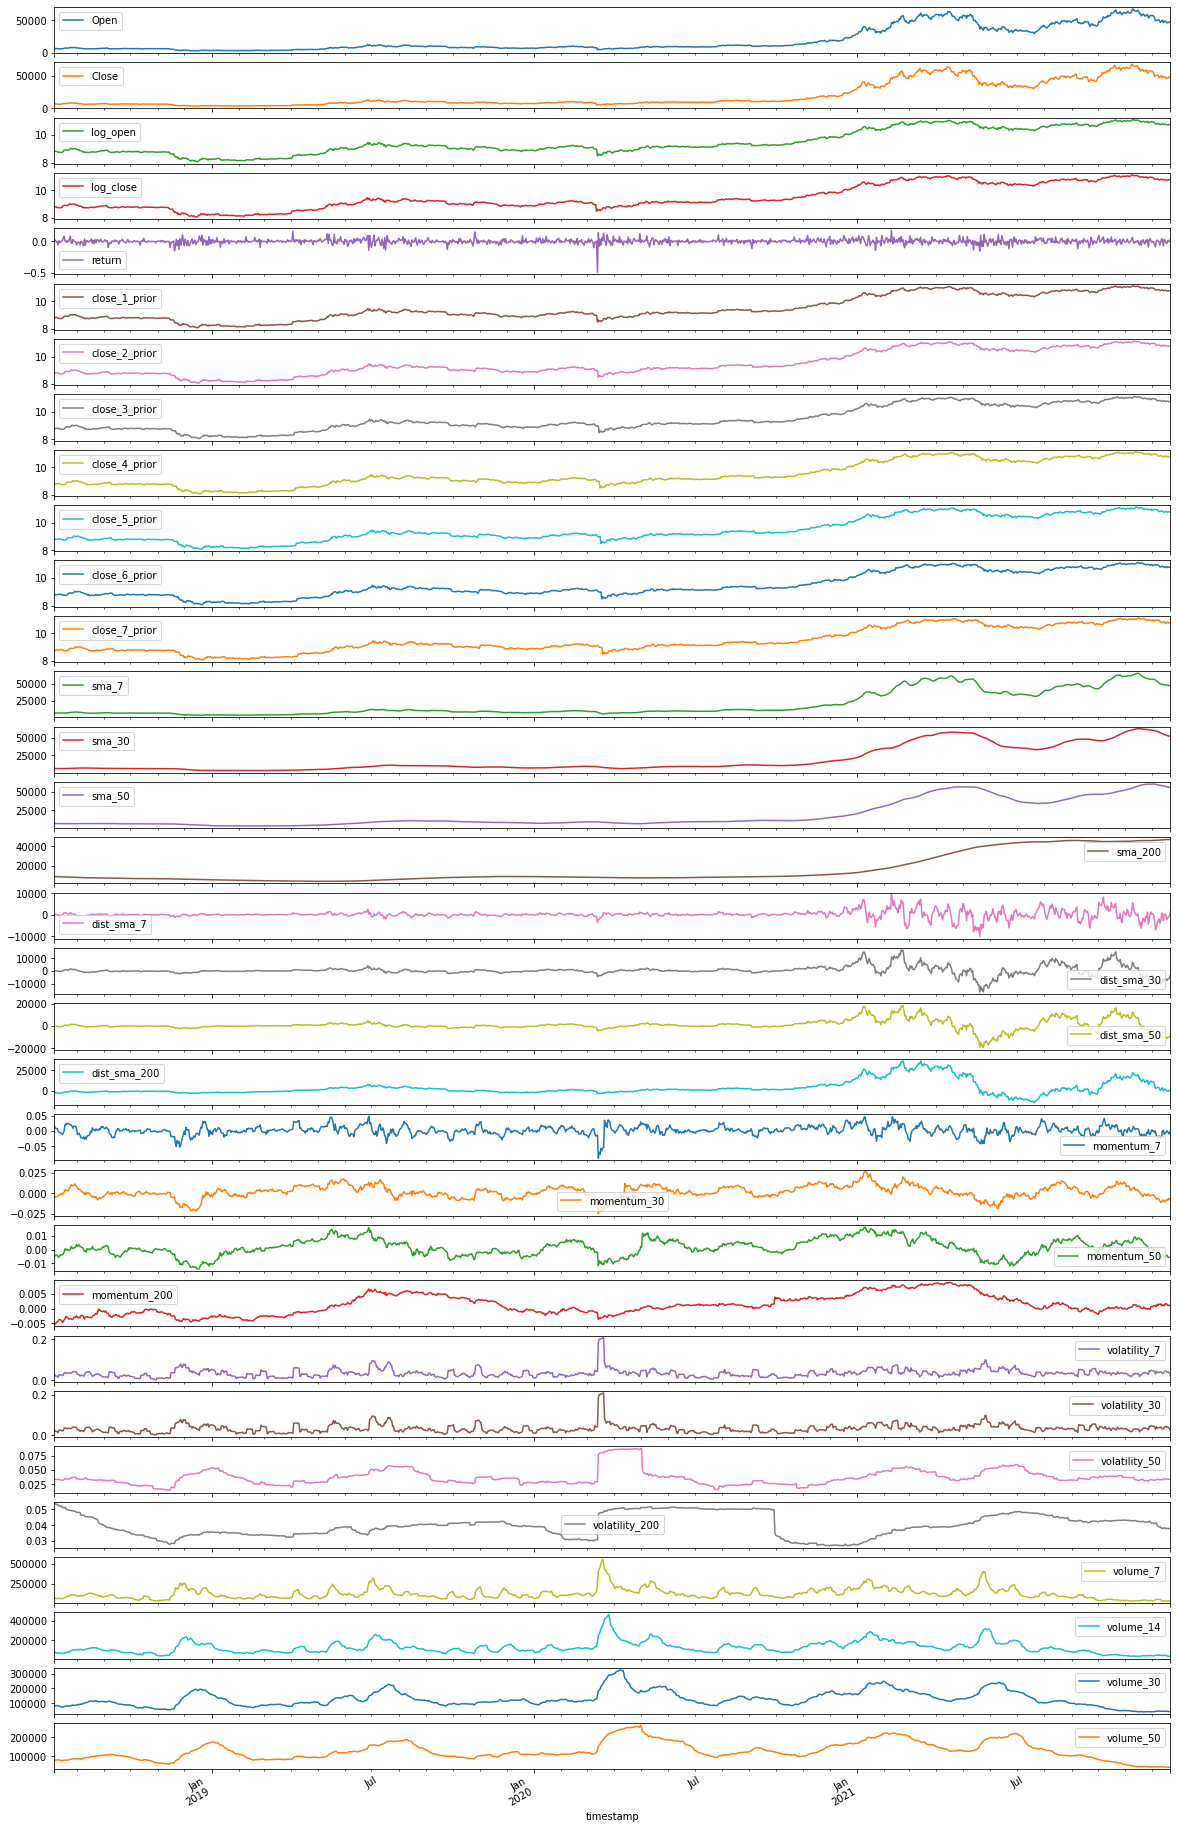

In [11]:
daily.plot(figsize=(20,36), subplots=True, legend=True);

In [12]:
corrs = daily.corr().stack().reset_index()
corrs.columns = ['1','2','R2']
corrs[(corrs.R2 > .8) & (corrs.R2 < 1)].sort_values('R2', ascending = False)

,1,2,R2
69,log_open,close_1_prior,1.000000
162,close_1_prior,log_open,1.000000
101,log_close,close_1_prior,0.998982
163,close_1_prior,log_close,0.998982
67,log_open,log_close,0.998982
...,...,...,...
79,log_open,sma_200,0.863688
111,log_close,sma_200,0.862346
483,sma_200,log_close,0.862346
725,momentum_50,momentum_30,0.801538


In [13]:
def create_lags(df, col = 'log_close', lags = 7):
    
    for i in range(1, lags+1):
        col_name = f'lag_{i}'
        df[col_name] = df['log_close'].shift(i)
    df.dropna(inplace = True)
        
    return df

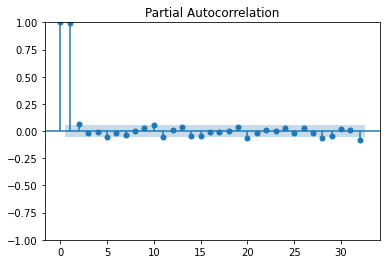

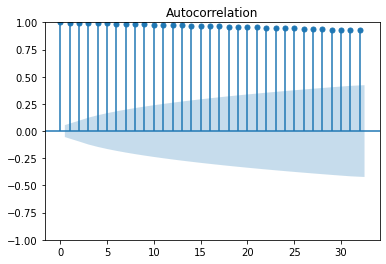

In [14]:
plot_pacf(daily['log_close']);
plot_acf(daily['log_close']);

In [15]:
def simple_moving_average(df, windows = [7,50,200]):
    for i in windows:
        col = f'sma_{i}'
        df[col] = df['Close'].rolling(i, min_periods = int(i*.75)).mean()
        df[col].plot(figsize = (40,10), legend = True, subplots = False)
    
    df['Close'].plot(legend = True);
    return df

In [16]:
def decomposition_plot(df):
        '''Takes time series dataframe and decompose it in order to observe trend, seasonality, and residuals'''
        decomposition = tsa.seasonal_decompose(df, period = 1, model = 'multiplicative', freq = 7)
        trend = decomposition.trend
        seasonal = decomposition.seasonal
        residual = decomposition.resid
        plt.figure(figsize=(10,7))
        plt.subplot(511)
        plt.plot(ts, label='Original', color='red')
        plt.legend(loc='best')
        plt.subplot(512)
        plt.plot(trend, label='Trend', color='blue')
        plt.legend(loc='best')
        plt.subplot(513)
        plt.plot(seasonal,label='Seasonality', color='orange')
        plt.legend(loc='best')
        plt.subplot(514)
        plt.plot(residual, label='Residuals', color='black')
        plt.legend(loc='best')
        plt.tight_layout()

In [17]:
### Seasonal Decomposition
def seasonal_decomposition(df):
    periods = [1,3,7,30,50,365]
    model = ['multiplicative', 'additive']

    combinations = []
    for x in periods:
        for y in model:
            combinations.append((x,y))
    
    adfullercombinations = []

    for i in combinations:
        components = tsa.seasonal_decompose(df, period = i[0], model = i[1])
        trend = components.trend
        seasonal = components.seasonal
        residual = components.resid
        observed = components.observed
        x = adfuller(residual.dropna())
        if x[1] < .05:
            adfullercombinations.append([i,x])
    
    return adfullercombinations

## Modeling
***

In [18]:
# p: The number of lag observations included in the model, also called the lag order.
# d: The number of times that the raw observations are differenced, also called the degree of differencing.
# q: The size of the moving average window, also called the order of moving average.

### ARMA

In [19]:
def ARMA_model(df, test_size = 3):
    
    x = daily.drop('log_close', axis = 1)
    x_train = x.head(len(x) - test_size)
    x_test = x.tail(test_size)

    y = daily['log_close']
    y_train = y.head(len(y) - test_size)
    y_test = y.tail(test_size)

    train_size = [len(y_train),500,250,100,50]
        
    aic_scores = []
    
    for p in range(0,3):
        for d in range(0,3):
            for size in train_size:
                model = ARMA(endog = y_train.tail(size), order =(p,d))
                fitmodel = model.fit()
                y_preds = fitmodel.forecast(test_size)
                rmse = np.sqrt(mean_squared_error(np.exp(y_test),np.exp(y_preds[0])))
                aic_scores.append(pd.DataFrame([size, (p,d), fitmodel.aic, rmse]).T)
                
    ARIMA_df = pd.concat(aic_scores, axis = 0)
    ARIMA_df.set_axis(['train_size', 'order', 'AIC', 'RMSE'], axis = 1, inplace = True)
    
    return ARIMA_df

In [21]:
arma = ARMA_model(daily)

NotImplementedError: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.


In [24]:
arma.sort_values('AIC').head(10)

NameError: name 'arma' is not defined

### ARIMA

In [26]:
def ARIMA_model(df, test_size = 3):
    
    x = daily.drop('log_close', axis = 1)
    x_train = x.head(len(x) - test_size)
    x_test = x.tail(test_size)

    y = daily['log_close']
    y_train = y.head(len(y) - test_size)
    y_test = y.tail(test_size)
    
    aicc_scores = []

    train_size = [len(y_train),500,250,100,50]

    for p in range(3):
        for q in range(1,3):
            for d in range(3):
                for size in train_size:
                    model = ARIMA(endog = y_train.tail(size), order =(p,q,d))
                    fitmodel = model.fit()
                    y_preds = fitmodel.forecast(test_size, exog = x_test)
                    rmse = np.sqrt(mean_squared_error(np.exp(y_test),np.exp(y_preds)))
                    aicc_scores.append(pd.DataFrame([size, (p,q,d), fitmodel.aicc, rmse]).T)
                    
    ARIMA_df = pd.concat(aicc_scores, axis = 0)
    ARIMA_df.set_axis(['train_size', 'order', 'AICC', 'RMSE'], axis = 1, inplace = True)
    
    return ARIMA_df

### ARIMAX

In [27]:
def ARIMAX_model(df, test_size = 3):
    
    x = daily.drop('log_close', axis = 1)
    x_train = x.head(len(x) - test_size)
    x_test = x.tail(test_size)

    y = daily['log_close']
    y_train = y.head(len(y) - test_size)
    y_test = y.tail(test_size)
    
    aicc_scores = []

    train_size = [len(y_train),500,250,100,50]

    for p in range(3):
        for q in range(1,3):
            for d in range(3):
                for size in train_size:
                    model = ARIMA(endog = y_train.tail(size), exog = x_train.tail(size), order =(p,q,d))
                    fitmodel = model.fit()
                    y_preds = fitmodel.forecast(test_size, exog = x_test)
                    rmse = np.sqrt(mean_squared_error(np.exp(y_test),np.exp(y_preds)))
                    aicc_scores.append(pd.DataFrame([size, (p,q,d), fitmodel.aicc, rmse]).T)
                    
    ARIMAX_df = pd.concat(aicc_scores, axis = 0)
    ARIMAX_df.set_axis(['train_size', 'order', 'AICC', 'RMSE'], axis = 1, inplace = True)
    
    return ARIMAX_df

In [28]:
arima = ARIMA_model(daily)

In [30]:
arimax = ARIMAX_model(daily)

### Backtesting

In [31]:
def backtesting(df, start_date = '2021-10-1', train_size = 250, test_size = 60):
    
    date = datetime.strptime(start_date, '%Y-%m-%d')
    
    earliest = date - timedelta(train_size)
    latest = date + timedelta(test_size)
    
    d = pd.date_range(start = date, end = latest)
    data = df[(df.index >= earliest) & (df.index <= latest)]
    
    X = data.drop(['log_close'], axis = 1)
    y = data['log_close']
    
    predictions = []
    
    for date in d:
        
        y_train = y[y.index < date][-(train_size):]
        X_train = X[X.index < date][-(train_size):]
        y_test = y[y.index == date]
        X_test = X[X.index == date]
        
        model = ARIMA(endog = y_train, exog = X_train, order =(2,2,2))
        fitmodel = model.fit()
        y_pred = fitmodel.forecast(1, exog = X_test)
        diff = np.exp(y_test[0]) - np.exp(y_pred[0])
        predictions.append([date, np.exp(y_pred)[0]])
    
    preds = pd.DataFrame(predictions, columns = ['timestamp', 'prediction']).set_index('timestamp')
    print(preds.index)
    df2 = data.merge(preds, on = 'timestamp')
    df2['log_predicted_return'] = np.log(df2['prediction'] / df2['Open'])
    
    return df2

In [32]:
first_preds = backtesting(daily, train_size = 50, test_size = 10)

DatetimeIndex(['2021-10-01', '2021-10-02', '2021-10-03', '2021-10-04',
               '2021-10-05', '2021-10-06', '2021-10-07', '2021-10-08',
               '2021-10-09', '2021-10-10', '2021-10-11'],
              dtype='datetime64[ns]', name='timestamp', freq=None)


In [33]:
first_preds

,Open,Close,log_open,log_close,return,close_1_prior,close_2_prior,close_3_prior,close_4_prior,close_5_prior,...,volatility_7,volatility_30,volatility_50,volatility_200,volume_7,volume_14,volume_30,volume_50,prediction,log_predicted_return
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-10-01,43825.73,48141.61,10.687976,10.781902,0.053906,10.687939,10.634034,10.621974,10.648927,10.672690,...,0.026918,0.026918,0.036426,0.042089,47385.731363,61663.206217,81395.812410,84026.463446,48200.724901,0.095153
2021-10-02,48141.60,47634.90,10.781902,10.771321,0.093963,10.781902,10.687939,10.634034,10.621974,10.648927,...,0.033172,0.033172,0.037271,0.042202,44829.934671,61783.642983,80478.598429,83240.099920,47511.813594,-0.013168
2021-10-03,47634.89,48200.01,10.771321,10.783115,-0.010581,10.771321,10.781902,10.687939,10.634034,10.621974,...,0.043484,0.043484,0.039428,0.042542,44389.136017,59929.309173,78162.095301,81877.001746,48119.874467,0.010130
2021-10-04,48200.01,49224.94,10.783115,10.804156,0.011794,10.783115,10.771321,10.781902,10.687939,10.634034,...,0.044128,0.044128,0.038052,0.042516,41667.001497,58306.248440,75517.608315,80826.259638,49340.395815,0.023384
2021-10-05,49224.93,51471.99,10.804155,10.848793,0.021041,10.804156,10.783115,10.771321,10.781902,10.687939,...,0.044122,0.044122,0.038023,0.042450,42669.808624,49825.923508,75056.303388,80160.697197,51627.441203,0.047653
2021-10-06,51471.99,55315.00,10.848793,10.920799,0.044637,10.848793,10.804156,10.783115,10.771321,10.781902,...,0.040534,0.040534,0.038132,0.042453,43920.295129,47516.271424,74334.657348,79223.142962,55570.988695,0.076624
2021-10-07,55315.00,53785.22,10.920799,10.892754,0.072006,10.920799,10.848793,10.804156,10.783115,10.771321,...,0.034682,0.034682,0.038457,0.042571,50391.117344,49054.020692,74131.732360,78585.150307,53437.346308,-0.034534
2021-10-08,53785.22,53951.43,10.892754,10.895839,-0.028045,10.892754,10.920799,10.848793,10.804156,10.783115,...,0.036190,0.036190,0.039454,0.042880,51610.567323,49498.149343,67735.054175,77637.898878,54118.625098,0.006180
2021-10-09,53955.67,54949.72,10.895918,10.914174,0.003085,10.895839,10.892754,10.920799,10.848793,10.804156,...,0.043768,0.043768,0.039715,0.042916,48744.482809,46787.208740,64898.739049,76553.469319,55157.778325,0.022035


In [34]:
first_preds['buy'] = np.where(first_preds['prediction'] > first_preds['Open'],first_preds['return'],0)

In [35]:
first_preds['prediction'] - first_preds['Open']

timestamp
2021-10-01    4374.994901
2021-10-02    -629.786406
2021-10-03     484.984467
2021-10-04    1140.385815
2021-10-05    2402.511203
2021-10-06    4098.998695
2021-10-07   -1877.653692
2021-10-08     333.405098
2021-10-09    1202.108325
2021-10-10    -593.296248
2021-10-11    3471.113303
dtype: float64

In [36]:
first_preds['Close'] - first_preds['Open']

timestamp
2021-10-01    4315.88
2021-10-02    -506.70
2021-10-03     565.12
2021-10-04    1024.93
2021-10-05    2247.06
2021-10-06    3843.01
2021-10-07   -1529.78
2021-10-08     166.21
2021-10-09     994.05
2021-10-10    -290.72
2021-10-11    2812.34
dtype: float64

## Results
***
TBD

## Conclusions and Next Steps
***
TBD